# Tools

In [1]:
import os, numpy as np, tqdm
from matplotlib import pyplot as plt
from matplotlib import rc
# rc('text', usetex=True)
font = {'family' : 'normal',
        'size'   : 16}
rc('font', **font)

In [2]:
%matplotlib notebook

In [3]:
import mantid.simpleapi as msa

/home/97n/miniconda3/envs/mcvine-py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Data

/SNS/ARCS/IPTS-10565/0/47644/NeXus/ARCS_47644_event.nxs: -0.49
/SNS/ARCS/IPTS-10565/0/47453/NeXus/ARCS_47453_event.nxs: 0.00
/SNS/ARCS/IPTS-10565/0/47643/NeXus/ARCS_47643_event.nxs: 0.51
/SNS/ARCS/IPTS-10565/0/47548/NeXus/ARCS_47548_event.nxs: 95.0

In [34]:
%%time
run2psi = {}
for runno in tqdm.tqdm(range(47548, 47644)):
    ws = msa.Load('/home/97n/data/ARCS/silicon/10565/0/{}/NeXus/ARCS_{}_event.nxs'.format(
        runno, runno))
    run = ws.getRun()
    p = run.getProperty('CCR12Rot')
    psi = p.value
    run2psi[runno] = psi

100%|██████████| 96/96 [04:46<00:00,  2.98s/it]

CPU times: user 6min 4s, sys: 5.67 s, total: 6min 10s
Wall time: 4min 46s


In [39]:
run2psi[47548], run2psi[47549], run2psi[47550], run2psi[47643], 

(array([94.998846, 94.998846]),
 array([94.504273, 94.504273]),
 array([93.505033, 93.505033]),
 array([0.50511, 0.50511]))

Just work on 47643--47549

# Reduction

In [5]:
runs = range(47549, 47643+1)

In [6]:
%%time
files = ['/home/97n/data/ARCS/silicon/10565/0/{}/NeXus/ARCS_{}_event.nxs'.format(
        runno, runno) for runno in runs]
files = ','.join(files)
wg = msa.Load(Filename=files)

CPU times: user 6min 15s, sys: 9.62 s, total: 6min 24s
Wall time: 4min 39s


In [7]:
%%time
msa.SetGoniometer(Workspace=wg, Axis0="CCR12Rot,0,1,0,1")

msa.DgsReduction(
    SampleInputWorkspace=wg, IncidentEnergyGuess=100., 
    SofPhiEIsDistribution=False, OutputWorkspace='reduced')

msa.CropWorkspaceForMDNorm("reduced", XMin=-50, XMax=90., OutputWorkspace='reduced')

msa.ConvertToMD(
    'reduced', 
    QDimensions='Q3D', 
    Q3DFrames='Q_sample',
    OutputWorkspace='md',
    MinValues='-15,-15,-15,-50',
    MaxValues='15,15,15,90.'
)
None

CPU times: user 15min 42s, sys: 29.6 s, total: 16min 11s
Wall time: 3min 49s


WorkspaceGroup
 -- ARCS_47549_event_reduced_md
 -- ARCS_47550_event_reduced_md
 -- ARCS_47551_event_reduced_md
 -- ARCS_47552_event_reduced_md
 -- ARCS_47553_event_reduced_md
 -- ARCS_47554_event_reduced_md
 -- ARCS_47555_event_reduced_md
 -- ARCS_47556_event_reduced_md
 -- ARCS_47557_event_reduced_md
 -- ARCS_47558_event_reduced_md
 -- ARCS_47559_event_reduced_md
 -- ARCS_47560_event_reduced_md
 -- ARCS_47561_event_reduced_md
 -- ARCS_47562_event_reduced_md
 -- ARCS_47563_event_reduced_md
 -- ARCS_47564_event_reduced_md
 -- ARCS_47565_event_reduced_md
 -- ARCS_47566_event_reduced_md
 -- ARCS_47567_event_reduced_md
 -- ARCS_47568_event_reduced_md
 -- ARCS_47569_event_reduced_md
 -- ARCS_47570_event_reduced_md
 -- ARCS_47571_event_reduced_md
 -- ARCS_47572_event_reduced_md
 -- ARCS_47573_event_reduced_md
 -- ARCS_47574_event_reduced_md
 -- ARCS_47575_event_reduced_md
 -- ARCS_47576_event_reduced_md
 -- ARCS_47577_event_reduced_md
 -- ARCS_47578_event_reduced_md
 -- ARCS_47579_event_redu

In [11]:
%%time
msa.MergeMD(InputWorkspaces='md', OutputWorkspace='merged')
None

CPU times: user 1min 9s, sys: 17.2 s, total: 1min 26s
Wall time: 4.55 s


In [12]:
merged_md_path = '/home/97n/data/ARCS/silicon/10565/merged_md.nxs'
msa.SaveMD('merged', merged_md_path)

# Slice

In [6]:
# merged = msa.Load(merged_md_path)

In [13]:
a,b,c,alpha,beta,gamma = 5.431, 5.431, 5.431, 90., 90., 90.

In [14]:
u = [-0.9986, 1.0283,-0.9716] 
v = [1.9976,0.9513,-1.0489] 

In [25]:
u = [-1, 1.,-1] 
v = [2,1,-1] 

In [26]:
msa.SetUB('merged', a=a, b=b, c=c, u=','.join(map(str, u)), v = ','.join(map(str,v)))

In [27]:
msa.MDNorm(
    'merged',
    QDimension0='1,0,0',
    QDimension1='0,1,0',
    QDimension2='0,0,1',
    Dimension0Name='QDimension0',
    Dimension0Binning='-10.0,0.1,3.4',
    Dimension1Name='QDimension1',
    Dimension1Binning='-9.0,0.1,7.0',
    Dimension2Name='QDimension2',
    Dimension2Binning='-10,10',
    Dimension3Name="DeltaE",
    Dimension3Binning='-5,20',
    OutputWorkspace='result',
    OutputDataWorkspace='dataMD',
    OutputNormalizationWorkspace='normMD'
)
None

In [20]:
from mantid import plots
from matplotlib.colors import LogNorm

<IPython.core.display.Javascript object>


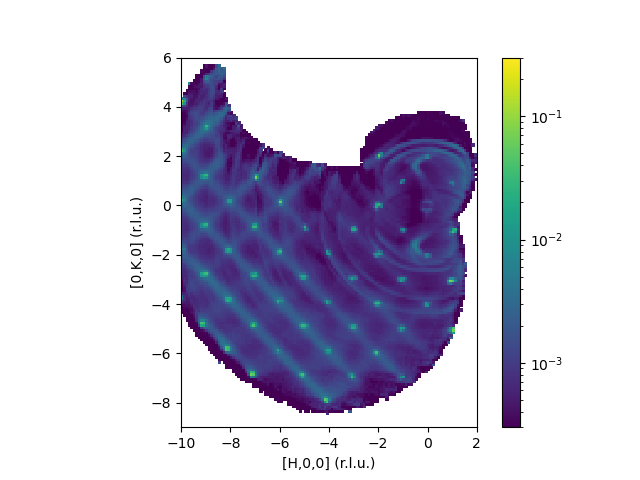

In [28]:
fig, ax = plt.subplots(subplot_kw={'projection':'mantid'})
cm = ax.pcolormesh(msa.mtd['result'], norm=LogNorm())
fig.colorbar(cm, ax=ax)
ax.set_aspect('equal')
ax.set_xlim(-10., 2)
ax.set_ylim(-9, 6)
cm.set_clim(3e-4, .3)